In [81]:
import numpy as np
from python_speech_features import mfcc
from scipy.spatial.distance import euclidean
import os
import pandas as pd
import concurrent.futures
from scipy.io import wavfile
from scipy.spatial.distance import cosine
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [82]:
# Function to read CSV data
def read_csv(file_path):
    return pd.read_csv(file_path)

In [83]:
# Function to load audio from file
def load_audio(audio_file):
    return wavfile.read(audio_file)

In [84]:
# Function to match IDs with audio file names
def match_audio_files(csv_data, audio_dir):
    id_to_audio = {}
    for index, row in csv_data.iterrows():
        audio_file = os.path.join(audio_dir, f"{row['id']}.wav")
        if os.path.exists(audio_file):
            id_to_audio[row['id']] = audio_file
    return id_to_audio

In [85]:
def compare_audio(new_audio_path, existing_audios, method='mfcc'):
    if not os.path.exists(new_audio_path):
     
        return False, False, False
    
    new_sr, new_audio = wavfile.read(new_audio_path)
    min_distance = float('inf')
    closest_match_id = None

    # Calculate MFCC for the new audio
    new_mfcc = mfcc(new_audio, samplerate=new_sr)

    # Iterate over existing audios
    for id_, (existing_sr, existing_audio) in existing_audios.items():
        # Check if sample rates are compatible
        
        # if new_sr == existing_sr:
            # Calculate MFCC for the existing audio
            existing_mfcc = mfcc(existing_audio, samplerate=existing_sr)
            
            # Calculate similarity between the new audio and existing audio
            if method == 'mfcc':
                # Euclidean distance between MFCC vectors
                similarity = euclidean(new_mfcc.mean(axis=0), existing_mfcc.mean(axis=0))
            # Add other methods here as needed
                
            else:
                raise ValueError("Invalid method specified.")
            
            # If similarity is high enough, consider the audios as matching
            if 60 < similarity < 62:  # Example threshold, adjust as needed
            # if similarity > 60: 
                print("similarity :",similarity) 
                closest_match_id = id_
                break
            elif similarity < 19:
                closest_match_id = id_
                break
    
    
    return closest_match_id, new_audio, new_sr

In [86]:
# Function to plot spectrogram
def plot_spectrogram(audio, sr, title):
    plt.figure(figsize=(10, 4))
    # Flatten the audio signal if it's multi-dimensional
    if len(audio.shape) > 1:
        audio = audio.flatten()
    plt.specgram(audio, Fs=sr, cmap='viridis', NFFT=1024, noverlap=512, scale='dB')
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(label='Intensity (dB)')
    plt.show()

In [87]:
# Main function
def main():
    start_time = time.time()
    
    # CSV file location and audio directory
    csv_file = r"E:\KERJA\spudniklab\InsecstopProjeck\data\metadata\data.csv"
    audio_dir = r"E:\KERJA\spudniklab\InsecstopProjeck\data\audio"

    # Read data from CSV
    csv_data = read_csv(csv_file)

    # Match IDs with audio file names
    id_to_audio = match_audio_files(csv_data, audio_dir)

    # Process audio in parallel
    with concurrent.futures.ProcessPoolExecutor() as executor:
        audio_data = {id_: load_audio(audio_file) for id_, audio_file in id_to_audio.items()}

    # Example of new audio
    new_audio_path = r"E:\KERJA\spudniklab\InsecstopProjeck\upload\72.wav"

    # Compare new audio with existing audio
    closest_match_id, new_audio, new_sr = compare_audio(new_audio_path, audio_data)
    
    if closest_match_id is False:
        return print("File not found.")
    
    # Plot spectrogram of new audio
    plot_spectrogram(new_audio, new_sr, 'New Audio Spectrogram')
    
    if closest_match_id:
        print(f"New audio is similar to the species with ID: {closest_match_id}.")

        
        # Plot spectrogram of the closest matching audio
        closest_match_audio = audio_data[closest_match_id][1]
        closest_match_sr = audio_data[closest_match_id][0]
        
        plot_spectrogram(closest_match_audio, closest_match_sr, f'Closest Match ({closest_match_id}) Spectrogram')
    else:
        print("No matching species found.")
        # Jika tidak ada kecocokan, tampilkan spektrogram untuk setiap audio dalam data CSV
        for id_, audio_info in audio_data.items():
            closest_match_audio = audio_data[id_][1]
            closest_match_sr = audio_data[id_][0]
            
            plot_spectrogram(closest_match_audio, closest_match_sr, f'Closest Match ({id_}) Spectrogram')
    
    print("Total time:", time.time() - start_time)

similarity : 60.867849174950734


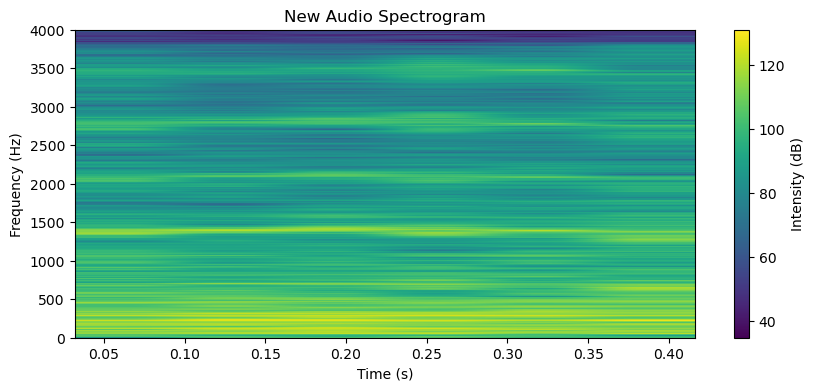

New audio is similar to the species with ID: 57.


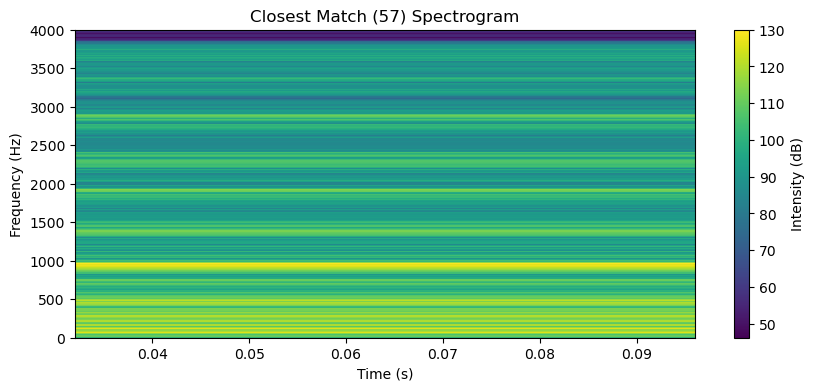

Total time: 1.3648686408996582


In [88]:
if __name__ == "__main__":
    main()